### Este es un notebook donde doy ejemplos de uso de las distintas funciones de mi librería flop_counter y sus interacciones con distintas librerías utilizadas en la ciencia de datos, de momento soporta NumPy, PyTorch y TensorFlow.

### Además, incluyo la fórmula que implementé para un análisis más similar al que hacen el AIC o el BIC

# $\color{#dda}{\text{0. Libs import}}$

Para la fecha en la que hago este jupyter no he hecho un paquete instalable universalmente así que se debe especificar el contexto de dónde está la librería de flop_counter.

In [1]:
import sys
import os

project_path = r'C:\Users\hecto\OneDrive\Escritorio\Personal\iroFactory\31.FLOPs-Information-Criterion'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

# Fix OpenMP
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import numpy as np
import flop_counter

# $\color{#dda}{\text{1. NumPy (simple)}}$

Función para NumPy con un modelo simple

In [2]:
def simple_numpy_model(x):
    """Modelo simple con NumPy"""
    W1 = np.random.randn(100, 50)
    W2 = np.random.randn(50, 10)
    
    h = np.matmul(x, W1)
    output = np.matmul(h, W2)
    return output

In [3]:
x = np.random.randn(32, 100)

result = flop_counter.count_model_flops(
    model=simple_numpy_model,
    input_data=x,
    framework='numpy',
    verbose=True
)

print(f"\nResultado retornado:")
print(f"  Total FLOPs: {result['total_flops']:,}")
print(f"  Tiempo: {result['execution_time_ms']:.2f} ms")


MODEL PROFILING SUMMARY

Model Information:
  Framework:     NUMPY
  Model Type:    function
  Model Name:    simple_numpy_model

Computational Complexity:
  Total FLOPs:   352,000
                 352.00 KFLOPs
  Execution Time: 4605.40 ms
  Throughput:     0.00 GFLOPS/s

Operation Breakdown (Top 10):
  Operation            Count    FLOPs           %       
  ------------------------------------------------------------
  matmul               2        352,000          100.0%



Resultado retornado:
  Total FLOPs: 352,000
  Tiempo: 4605.40 ms


# $\color{#dda}{\text{2. PyTorch (simple)}}$

Función para PyTorch con una red neuronal simple

In [ ]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
model = SimpleNet()
x = torch.randn(32, 784)

result = flop_counter.count_model_flops(
    model=model,
    input_data=x,
    verbose=True
)

print(f"\nDetalles del resultado:")
print(f"  Framework detectado: {result['framework']}")
print(f"  Parámetros del modelo: {result['model_info'].get('total_parameters', 'N/A'):,}")


MODEL PROFILING SUMMARY

Model Information:
  Framework:     TORCH
  Model Type:    SimpleNet
  Model Name:    SimpleNet
  Parameters:    235,146
  Trainable:     235,146

Computational Complexity:
  Total FLOPs:   44,580,864
                 44.58 MFLOPs
  Execution Time: 34.76 ms
  Throughput:     1.28 GFLOPS/s

Operation Breakdown (Top 10):
  Operation            Count    FLOPs           %       
  ------------------------------------------------------------
  F.linear             3        44,580,864       100.0%



Detalles del resultado:
  Framework detectado: torch
  Parámetros del modelo: 235,146


# $\color{#dda}{\text{3. Comparación entre modelos}}$

Comparamos distintos tamaños de modelos (operaciones de matrices en este caso) con compare_models(), que recibe un diccionario de str y tupla, donde la tupla es el modelo y un ndarray random.

In [ ]:
def model_small(x):
    """Modelo pequeño"""
    W = np.random.randn(100, 10)
    return np.matmul(x, W)

def model_medium(x):
    """Modelo mediano"""
    W1 = np.random.randn(100, 50)
    W2 = np.random.randn(50, 10)
    h = np.matmul(x, W1)
    return np.matmul(h, W2)

def model_large(x):
    """Modelo grande"""
    W1 = np.random.randn(100, 200)
    W2 = np.random.randn(200, 100)
    W3 = np.random.randn(100, 10)
    h1 = np.matmul(x, W1)
    h2 = np.matmul(h1, W2)
    return np.matmul(h2, W3)

In [7]:
x = np.random.randn(32, 100)

models = {
    'Small': (model_small, x),
    'Medium': (model_medium, x),
    'Large': (model_large, x)
}

results = flop_counter.compare_models(models, framework='numpy', verbose=True)


Profiling: Small
--------------------------------------------------

Profiling: Medium
--------------------------------------------------

Profiling: Large
--------------------------------------------------

MODEL COMPARISON

Model                FLOPs           Time (ms)    GFLOPS/s    
----------------------------------------------------------------------
Small                64,000          0.81         0.08        
Medium               352,000         3.43         0.10        
Large                2,624,000       7.80         0.34        

Most Efficient: Small (64,000 FLOPs)

Efficiency Ratios (vs Small):
  Medium: 5.50x more FLOPs
  Large: 41.00x more FLOPs




# $\color{#dda}{\text{4. Sin verbose, solo FLOPs}}$

Hasta este punto todo el texto que manda es verbose, para obtener solo los FLOPs se puede marcar ```verbose=False``` en count_model_flops()

In [ ]:
def my_model(x):
    W = np.random.randn(50, 25)
    return np.matmul(x, W)

In [9]:
x = np.random.randn(16, 50)

# Obtener solo el número de FLOPs
flops = flop_counter.count_model_flops(
    model=my_model,
    input_data=x,
    verbose=False,
    return_details=False
)

print(f"FLOPs calculados: {flops:,}")

FLOPs calculados: 40,000


# $\color{#dda}{\text{5. PyTorch (complejo)}}$

Count para una CNN que procesa imágenes de 32x32 (RGB)

In [40]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [41]:
x = torch.randn(1, 3, 32, 32)  # Imagen 32x32 RGB
img = x[0].permute(1, 2, 0).detach().cpu().numpy()

# Normalizar valores a [0,1] para visualización
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

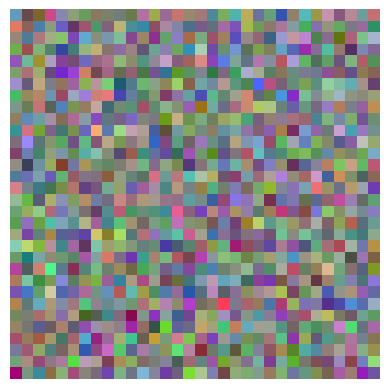

In [42]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [43]:
model = SimpleCNN()

result = flop_counter.count_model_flops(
    model=model,
    input_data=x,
    verbose=True
)


MODEL PROFILING SUMMARY

Model Information:
  Framework:     TORCH
  Model Type:    SimpleCNN
  Model Name:    SimpleCNN
  Parameters:    25,578
  Trainable:     25,578

Computational Complexity:
  Total FLOPs:   11,632,640
                 11.63 MFLOPs
  Execution Time: 6.03 ms
  Throughput:     1.93 GFLOPS/s

Operation Breakdown (Top 10):
  Operation            Count    FLOPs           %       
  ------------------------------------------------------------
  F.linear             1        8,388,608         72.1%
  F.conv2d             2        3,244,032         27.9%




# $\color{#dda}{\text{6. Análisis de eficiencia}}$

Determinamos eficiencia a partir de tiempo de ejecución. Creo que no le daré mucha importancia al tiempo ni a la memoria porque depende de muchos factores, entre ellos, especificaciones de hardware. Lo coloco igual para que se vea que es posible.

In [ ]:
def analyze_efficiency(model_fn, input_data, model_name):
    """Analiza la eficiencia de un modelo."""
    result = flop_counter.count_model_flops(
        model=model_fn,
        input_data=input_data,
        verbose=False,
        return_details=True
    )
    
    flops = result['total_flops']
    time_ms = result['execution_time_ms']
    
    # Calcular métricas
    throughput = (flops / (time_ms / 1000)) / 1e9  # GFLOPS/s
    
    # Obtener tamaño de salida
    output_shape = result.get('output_shape', None)
    
    print(f"\n{model_name}:")
    print(f"  FLOPs:      {flops:,}")
    print(f"  Time:       {time_ms:.2f} ms")
    print(f"  Throughput: {throughput:.2f} GFLOPS/s")
    if output_shape:
        print(f"  Output:     {output_shape}")
    
    return result

In [45]:
# Crear varios modelos de diferentes tamaños
input_data = np.random.randn(32, 128)

def tiny_model(x):
    return np.matmul(x, np.random.randn(128, 10))

def small_model(x):
    h = np.matmul(x, np.random.randn(128, 64))
    return np.matmul(h, np.random.randn(64, 10))

def medium_model(x):
    h1 = np.matmul(x, np.random.randn(128, 128))
    h2 = np.matmul(h1, np.random.randn(128, 64))
    return np.matmul(h2, np.random.randn(64, 10))

In [46]:
results = {
    'Tiny': analyze_efficiency(tiny_model, input_data, 'Tiny Model'),
    'Small': analyze_efficiency(small_model, input_data, 'Small Model'),
    'Medium': analyze_efficiency(medium_model, input_data, 'Medium Model')
}

# Comparar eficiencia
print(f"\n{'Model':<15} {'FLOPs':<15} {'Time (ms)':<12} {'Efficiency':<15}")
print("-" * 60)
for name, result in results.items():
    flops = result['total_flops']
    time_ms = result['execution_time_ms']
    efficiency = flops / time_ms if time_ms > 0 else 0
    print(f"{name:<15} {flops:<15,} {time_ms:<12.2f} {efficiency:<15,.0f}")


Tiny Model:
  FLOPs:      81,920
  Time:       1.16 ms
  Throughput: 0.07 GFLOPS/s
  Output:     (32, 10)

Small Model:
  FLOPs:      565,248
  Time:       1.10 ms
  Throughput: 0.51 GFLOPS/s
  Output:     (32, 10)

Medium Model:
  FLOPs:      1,613,824
  Time:       8.57 ms
  Throughput: 0.19 GFLOPS/s
  Output:     (32, 10)

Model           FLOPs           Time (ms)    Efficiency     
------------------------------------------------------------
Tiny            81,920          1.16         70,743         
Small           565,248         1.10         513,675        
Medium          1,613,824       8.57         188,419        


# $\color{#dda}{\text{7. Detección automática de framework/lib}}$

Solo un ejemplo de que si se deja ```framework='auto'``` puede detectar qué librería se está utilizando

In [ ]:
# NumPy
def numpy_fn(x):
    return np.matmul(x, np.random.randn(50, 10))

In [48]:
x_np = np.random.randn(32, 50)

result_np = flop_counter.count_model_flops(
    model=numpy_fn,
    input_data=x_np,
    framework='auto',  # Detectar automáticamente
    verbose=False
)

print(f"NumPy model - Framework detectado: {result_np['framework']}")
print(f"FLOPs: {result_np['total_flops']:,}")

NumPy model - Framework detectado: numpy
FLOPs: 32,000


In [49]:
import torch

def torch_fn(x):
    W = torch.randn(50, 10)
    return torch.matmul(x, W)

In [50]:
x_torch = torch.randn(32, 50)

result_torch = flop_counter.count_model_flops(
    model=torch_fn,
    input_data=x_torch,
    framework='auto',  # Detectar automáticamente
    verbose=False
)

print(f"\nPyTorch model - Framework detectado: {result_torch['framework']}")
print(f"FLOPs: {result_torch['total_flops']:,}")


PyTorch model - Framework detectado: torch
FLOPs: 32,000


# $\color{#dda}{\text{8. Operation Breakdown}}$

En caso de que se quieran realizar optimizaciones o encontrar movimientos y demás, separa los tipos de operaciones encontrados en el contexto. Por lo general serán matmul para la mayoría de casos pero podría utilizarse más propiamente en modelos de predicción y series de tiempo.

In [ ]:
def complex_model(x):
    """Modelo con múltiples tipos de operaciones."""
    # Capas fully connected
    h1 = np.matmul(x, np.random.randn(100, 256))
    h2 = np.matmul(h1, np.random.randn(256, 128))
    h3 = np.matmul(h2, np.random.randn(128, 10))
    
    # Operaciones de reducción
    mean_h3 = np.mean(h3)
    std_h3 = np.std(h3)
    sum_h3 = np.sum(h3)
    
    return h3

In [ ]:
x = np.random.randn(32, 100)

result = flop_counter.count_model_flops(
    model=complex_model,
    input_data=x,
    verbose=False,
    return_details=True
)


Breakdown por tipo de operación:
Operación            FLOPs           % del Total 
--------------------------------------------------


In [ ]:
print("\nBreakdown por tipo de operación:")
print(f"{'Operación':<20} {'FLOPs':<15} {'% del Total':<12}")
print("-" * 50)

total = result['total_flops']
for op_name, op_flops in sorted(result['flops_by_operation'].items(), 
                                key=lambda x: x[1], reverse=True):
    percentage = (op_flops / total * 100) if total > 0 else 0
    print(f"{op_name:<20} {op_flops:<15,} {percentage:>10.1f}%")

print(f"\nTotal: {total:,} FLOPs")

matmul               3,817,472            100.0%
mean                 320                    0.0%
std                  320                    0.0%
sum                  320                    0.0%

Total: 3,818,432 FLOPs


# $\color{#dda}{\text{Conclusión y resumen}}$

## count_model_flops()

La función **`count_model_flops()`** proporciona:

- ✅ Detección automática de framework  
- ✅ Conteo preciso de FLOPs  
- ✅ Información detallada del modelo  
- ✅ Medición de tiempo de ejecución  
- ✅ Breakdown por operación  
- ✅ Comparación fácil entre modelos  

---

### Uso básico

```python
result = flop_counter.count_model_flops(model, input_data)
```

### Más de un modelo
```python
results = flop_counter.compare_models({
    'model1': (model1, input1),
    'model2': (model2, input2)
})
```

## ¡EUREKA!

### Ya con todo lo de este notebook es posible crear una fórmula estadística más robusta para determinar el FIC (FLOP Information Criterion)